
# Bench Buddy Simulation
This notebook builds a lightweight "physics-aware" version of the bench-press scenario:
- The arms follow a prescribed trajectory (we still control them directly).
- The bar's vertical motion is integrated under gravity and then clamped to the hands, so it free-falls until the spotter reaches it.
- Bench / torso / neck / head remain welded to the world for context.

Every section is documented so you can tweak waypoints, gravity, or contact parameters without digging into the core module.



## Notebook roadmap
1. Define helper dataclasses and the `BenchBuddySimulation` class that loads the same SDF assets as the original project.
2. Integrate a simple gravitational model for the bar while keeping kinematic control of both arms.
3. Spin up MeshCat, configure a lift scenario, run the simulation, and visualize both the recording and position traces.
4. Highlight the approximations (e.g., hand contact modeled as a clamp) so you can iterate further.


In [15]:

from __future__ import annotations

import math
from dataclasses import dataclass
from pathlib import Path
from typing import List, Sequence

import matplotlib.pyplot as plt
import numpy as np

import bench_buddy
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Parser,
    RigidTransform,
    RotationMatrix,
    StartMeshcat,
)

_ASSETS_DIR = Path(bench_buddy.__file__).resolve().parent.parent / "assets"


In [16]:

@dataclass
class LiftWaypoint:
    """Relative Cartesian offset (in meters) for a single waypoint."""

    name: str
    relative_position: Sequence[float]
    hold_time: float = 0.15


@dataclass
class SimulationConfig:
    """Inputs that define a rollout for the simulation."""

    waypoints: List[LiftWaypoint]
    peak_bar_velocity: float = 0.45
    sample_rate_hz: float = 240.0
    gravity: float = -9.81  # m/s^2 acting in +Z -> negative value
    clamp_clearance: float = 0.03  # meters above each palm where the bar is captured
    meshcat: object | None = None
    show_meshcat: bool = True


@dataclass
class SimulationResult:
    times: List[float]
    bar_positions: List[np.ndarray]
    bar_velocities: List[np.ndarray]
    left_positions: List[np.ndarray]
    right_positions: List[np.ndarray]


In [17]:

@dataclass
class _TrajectoryBundle:
    times: List[float]
    left_positions: List[np.ndarray]
    right_positions: List[np.ndarray]
    left_velocities: List[np.ndarray]
    right_velocities: List[np.ndarray]


In [18]:

class BenchBuddySimulation:
    """Kinematic arms + gravity-assisted bar visualization."""

    _BENCH_IN_WORLD = np.array([-0.15, 0.0, 0.127])
    _TORSO_IN_WORLD = np.array([-0.45, 0.0, 0.697])
    _NECK_IN_WORLD = np.array([-0.10, 0.0, 0.697])
    _HEAD_IN_WORLD = np.array([0.0, 0.0, 0.697])
    _LEFT_ARM_HOME = np.array([-0.2, 0.2, 0.697])
    _RIGHT_ARM_HOME = np.array([-0.2, -0.2, 0.697])
    _BAR_RACK_HOME = np.array([-0.06, 0.0, 0.93])
    _RACK_HOME = np.array([-0.15, 0.0, 0.127])
    _HAND_OFFSET_IN_ARM = np.array([0.30, 0.0, 0.0])

    def __init__(self, config: SimulationConfig):
        self.config = config
        self.meshcat = config.meshcat or StartMeshcat()

        self.builder = DiagramBuilder()
        self.plant, self.scene_graph = AddMultibodyPlantSceneGraph(self.builder, time_step=0.0)
        self.parser = Parser(self.plant, self.scene_graph)
        self._load_environment()
        self.plant.Finalize()

        MeshcatVisualizer.AddToBuilder(
            self.builder, self.scene_graph, self.meshcat, MeshcatVisualizerParams()
        )
        self.diagram = self.builder.Build()
        self.context = self.diagram.CreateDefaultContext()
        self.plant_context = self.plant.GetMyMutableContextFromRoot(self.context)

    def simulate(self) -> SimulationResult:
        traj = self._synthesize_arm_trajectory()
        dt = 1.0 / self.config.sample_rate_hz
        gravity_vec = np.array([0.0, 0.0, self.config.gravity])

        bar_pos = self._BAR_RACK_HOME.copy()
        bar_vel = np.zeros(3)
        bar_positions: List[np.ndarray] = []
        bar_velocities: List[np.ndarray] = []

        for t, left, right, left_v, right_v in zip(
            traj.times, traj.left_positions, traj.right_positions, traj.left_velocities, traj.right_velocities
        ):
            bar_pos, bar_vel = self._step_bar(bar_pos, bar_vel, left, right, left_v, right_v, gravity_vec, dt)
            bar_positions.append(bar_pos.copy())
            bar_velocities.append(bar_vel.copy())

        if self.config.show_meshcat:
            self._record_meshcat(traj, bar_positions)

        return SimulationResult(
            times=traj.times,
            bar_positions=bar_positions,
            bar_velocities=bar_velocities,
            left_positions=traj.left_positions,
            right_positions=traj.right_positions,
        )

    def _synthesize_arm_trajectory(self) -> _TrajectoryBundle:
        dt = 1.0 / self.config.sample_rate_hz
        waypoints = [LiftWaypoint("home", [0, 0, 0], hold_time=0.2)]
        waypoints.extend(self.config.waypoints)
        waypoints.append(LiftWaypoint("home_return", [0, 0, 0], hold_time=0.2))

        left_positions: List[np.ndarray] = []
        right_positions: List[np.ndarray] = []
        times: List[float] = []

        t = 0.0
        last_left = self._LEFT_ARM_HOME.copy()
        last_right = self._RIGHT_ARM_HOME.copy()

        for idx, wp in enumerate(waypoints[:-1]):
            next_wp = waypoints[idx + 1]
            rel_a = np.asarray(wp.relative_position, dtype=float)
            rel_b = np.asarray(next_wp.relative_position, dtype=float)
            world_a_left = self._LEFT_ARM_HOME + rel_a
            world_b_left = self._LEFT_ARM_HOME + rel_b
            world_a_right = self._RIGHT_ARM_HOME + rel_a
            world_b_right = self._RIGHT_ARM_HOME + rel_b

            segment_length = np.linalg.norm(world_b_left - world_a_left)
            duration = max(segment_length / max(self.config.peak_bar_velocity, 1e-3), 0.05)
            samples = max(1, int(math.ceil(duration / dt)))

            for step in range(samples):
                alpha = (step + 1) / samples
                left = (1 - alpha) * world_a_left + alpha * world_b_left
                right = (1 - alpha) * world_a_right + alpha * world_b_right
                t += dt
                left_positions.append(left)
                right_positions.append(right)
                times.append(t)
                last_left = left
                last_right = right

            dwell = max(1, int(math.ceil(next_wp.hold_time / dt)))
            for _ in range(dwell):
                t += dt
                left_positions.append(last_left.copy())
                right_positions.append(last_right.copy())
                times.append(t)

        left_arr = np.array(left_positions)
        right_arr = np.array(right_positions)
        left_vel = np.gradient(left_arr, dt, axis=0)
        right_vel = np.gradient(right_arr, dt, axis=0)

        return _TrajectoryBundle(
            times=times,
            left_positions=list(left_arr),
            right_positions=list(right_arr),
            left_velocities=list(left_vel),
            right_velocities=list(right_vel),
        )

    def _step_bar(self, bar_pos, bar_vel, left, right, left_vel, right_vel, gravity_vec, dt):
        next_vel = bar_vel + gravity_vec * dt
        next_pos = bar_pos + next_vel * dt
        next_pos[:2] = 0.5 * (left[:2] + right[:2])

        arm_support = min(left[2], right[2]) + self.config.clamp_clearance
        rack_support = self._BAR_RACK_HOME[2] + self.config.clamp_clearance
        clamp_height = max(rack_support, arm_support)
        if next_pos[2] < clamp_height:
            next_pos[2] = clamp_height
            if clamp_height > arm_support:
                next_vel[2] = 0.0
            else:
                support_vel = 0.5 * (left_vel[2] + right_vel[2])
                next_vel[2] = support_vel
        return next_pos, next_vel

    def _load_environment(self):
        wf = self.plant.world_frame()
        bench = self.parser.AddModels(str(_ASSETS_DIR / "bench.sdf"))[0]
        bench_frame = self.plant.GetFrameByName("bench", bench)
        self.plant.WeldFrames(wf, bench_frame, RigidTransform(p=self._BENCH_IN_WORLD))

        torso = self.parser.AddModels(str(_ASSETS_DIR / "torso.sdf"))[0]
        neck = self.parser.AddModels(str(_ASSETS_DIR / "neck.sdf"))[0]
        head = self.parser.AddModels(str(_ASSETS_DIR / "head.sdf"))[0]

        self.plant.WeldFrames(
            bench_frame,
            self.plant.GetFrameByName("torso", torso),
            RigidTransform(p=self._TORSO_IN_WORLD - self._BENCH_IN_WORLD),
        )
        self.plant.WeldFrames(
            self.plant.GetFrameByName("torso", torso),
            self.plant.GetFrameByName("neck", neck),
            RigidTransform(p=self._NECK_IN_WORLD - self._TORSO_IN_WORLD),
        )
        self.plant.WeldFrames(
            self.plant.GetFrameByName("neck", neck),
            self.plant.GetFrameByName("head", head),
            RigidTransform(p=self._HEAD_IN_WORLD - self._NECK_IN_WORLD),
        )

        rack = self.parser.AddModels(str(_ASSETS_DIR / "rack.sdf"))[0]
        self.plant.WeldFrames(wf, self.plant.GetFrameByName("rack", rack), RigidTransform(p=self._RACK_HOME))

        self.left_arm_model = self.parser.AddModels(str(_ASSETS_DIR / "left_arm.sdf"))[0]
        self.right_arm_model = self.parser.AddModels(str(_ASSETS_DIR / "right_arm.sdf"))[0]
        self.left_hand_model = self.parser.AddModels(str(_ASSETS_DIR / "left_hand.sdf"))[0]
        self.right_hand_model = self.parser.AddModels(str(_ASSETS_DIR / "right_hand.sdf"))[0]
        self.bar_model = self.parser.AddModels(str(_ASSETS_DIR / "bar.sdf"))[0]

        self.left_arm_body = self.plant.GetBodyByName("left_arm", self.left_arm_model)
        self.right_arm_body = self.plant.GetBodyByName("right_arm", self.right_arm_model)
        self.left_hand_body = self.plant.GetBodyByName("left_hand", self.left_hand_model)
        self.right_hand_body = self.plant.GetBodyByName("right_hand", self.right_hand_model)
        self.bar_body = self.plant.GetBodyByName("bar", self.bar_model)

    def _record_meshcat(self, traj: _TrajectoryBundle, bar_positions: List[np.ndarray]):
        self.meshcat.Delete()
        self.meshcat.DeleteAddedControls()
        self.meshcat.StartRecording(set_visualizations_while_recording=False)
        bar_rotation = RotationMatrix.MakeYRotation(math.pi / 2.0)
        arm_rotation = RotationMatrix.MakeYRotation(-math.pi / 2.0)

        for t, left, right, bar in zip(
            traj.times, traj.left_positions, traj.right_positions, bar_positions
        ):
            self.context.SetTime(t)
            self.plant.SetFreeBodyPose(
                self.plant_context, self.left_arm_body, RigidTransform(R=arm_rotation, p=left)
            )
            self.plant.SetFreeBodyPose(
                self.plant_context, self.right_arm_body, RigidTransform(R=arm_rotation, p=right)
            )
            self.plant.SetFreeBodyPose(
                self.plant_context, self.bar_body, RigidTransform(R=bar_rotation, p=bar)
            )
            self.diagram.ForcedPublish(self.context)

        self.meshcat.StopRecording()
        if self.config.show_meshcat:
            self.meshcat.PublishRecording()

    @staticmethod
    def plot(result: SimulationResult):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
        times = result.times
        bar = np.array(result.bar_positions)
        left = np.array(result.left_positions)
        right = np.array(result.right_positions)

        ax1.plot(times, bar[:, 2], label="bar z", linewidth=2)
        ax1.plot(times, left[:, 2], label="left hand z", linestyle="--")
        ax1.plot(times, right[:, 2], label="right hand z", linestyle=":")
        ax1.set_ylabel("Height (m)")
        ax1.legend()
        ax1.grid(True)

        bar_speed = np.linalg.norm(np.array(result.bar_velocities), axis=1)
        ax2.plot(times, bar_speed, label="|bar velocity|", color="C3")
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Speed (m/s)")
        ax2.grid(True)
        ax2.legend()
        fig.tight_layout()
        return fig



## Start MeshCat
Run the next cell to launch a viewer instance (URL printed below). Re-run it if you restart the kernel so `meshcat` stays valid.


In [19]:
meshcat = StartMeshcat()
print(f'MeshCat URL: {meshcat.web_url()}')

INFO:drake:Meshcat listening for connections at http://localhost:7002


MeshCat URL: http://localhost:7002



## Configure the gravity-assisted lift
Below we specify a few waypoints (relative to the home pose) and build the simulation. Tweak the waypoints, gravity, or clamp clearance to explore different behaviors.


In [20]:

waypoints = [
    LiftWaypoint("lower_to_chest", [0.0, 0.0, -0.30], hold_time=0.2),
    LiftWaypoint("press", [0.0, 0.0, 0.25], hold_time=0.2),
]

config = SimulationConfig(
    waypoints=waypoints,
    peak_bar_velocity=0.50,
    sample_rate_hz=240.0,
    gravity=-9.81,
    clamp_clearance=0.035,
    meshcat=meshcat,
    show_meshcat=True,
)

sim = BenchBuddySimulation(config)



## Run the simulation
Executing the next cell integrates the bar's vertical motion under gravity, clamps it to the hands when they reach it, and records a MeshCat animation plus a simple plot.


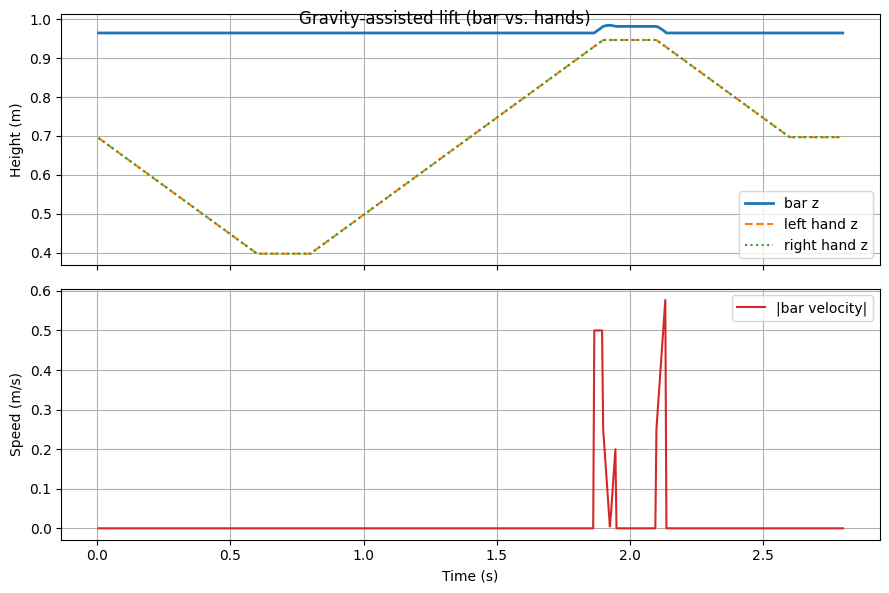

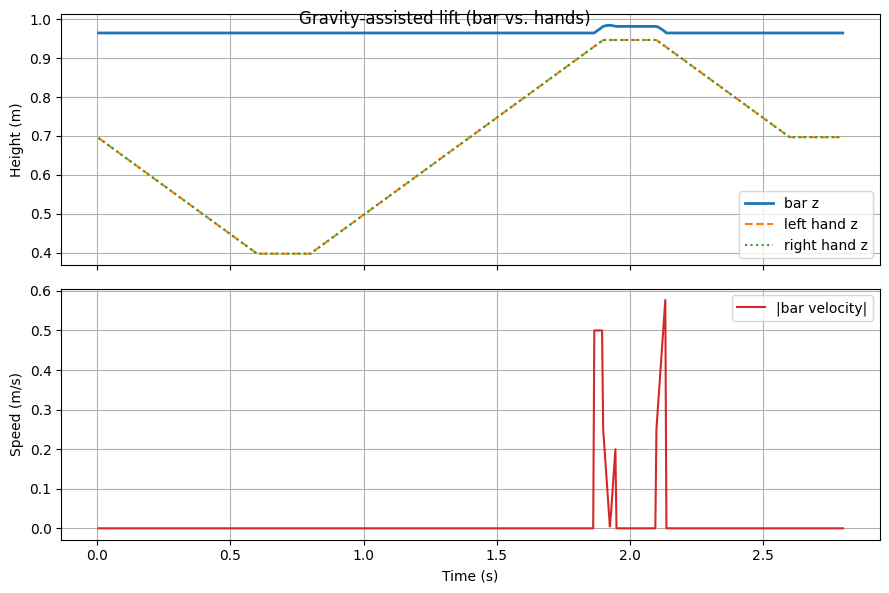

In [21]:

result = sim.simulate()
fig = sim.plot(result)
fig.suptitle("Gravity-assisted lift (bar vs. hands)")
fig



## Notes & next steps
- The clamp model is intentionally simple: we detect when the bar drops into either hand and then glue it to the average hand height. Replace `_step_bar` with a more sophisticated contact model if you need torque-based coupling.
- The bar's lateral motion always mirrors the midpoint between both hands; if you want to allow drifting, remove the `next_pos[:2] = ...` line.
- To experiment with different hand geometries, edit `assets/left_arm.sdf` and `assets/right_arm.sdf` (or create new SDFs such as `arm_improved.sdf`) and change the filenames inside `_load_environment`.
